<a href="https://colab.research.google.com/github/r-diazp/covid19/blob/master/time_series_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias y Funciones

In [124]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta
import time

from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

In [2]:
#Revisar si la GPU esta habilitda y modelo 
print(f'- GPU available: {torch.cuda.is_available()} \
      \n- GPU: {torch.cuda.get_device_name(0)}')

- GPU available: True       
- GPU: Tesla K80


In [116]:
#@title
#Determinar casos diarios (Ya que los datos vienen acumulados)
def daily_cases(data_frame):
  daily_cases, j = [], 0
  for j in range(len(data_frame) ):
    if j==0:
      daily_cases.append(data_frame[j:j+1].item() )
    else:  
      daily_cases.append(data_frame[j:j+1].item() - data_frame[j-1:j].item() )
  return np.array(daily_cases)

#Determinar ventana 
def input_data(sequence, windows_size):  #Windows_size tamaño de la ventana 
  output = []
  L = len(sequence)
  for i in range(L - windows_size):
      window = sequence[i : i + windows_size]
      label = sequence[i + windows_size : i + windows_size+1]
      output.append((window, label))
  return output


#Funcion para graficar los resultados 
def grafic_result(data_frame, x_train_plot, window_size, figsize=(12,4), type=1):  
  if (type):
    x_test_plot = np.array(df.index[-window_size:], dtype='datetime64[M]')
  else:
    x_test_plot = np.arange(df.index[-1], df.index[-1] + relativedelta(months=+future), dtype='datetime64[M]')
  
  plt.figure(figsize=figsize)
  plt.title('Real VS Prediciones ')
  plt.grid(True)
  plt.autoscale(axis='x',tight=True)
  plt.plot(df.iloc[:,0][df.index[-x_train_plot:]])
  plt.plot(x_test_plot, predictions_test, "orange")
  plt.show()

#Funcion para entrenamiento de modelos
def model_fit(epochs, data, model, criterion, optimizer):
  losses = []
  start_time = time.time()
  for epoch in range(epochs):    
      # Extraer sequence & target de los datos de entrenamiento 
      
      for sequence, target in data:        
        # Resetear el estado de los parametros de la capa oculta 
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                        torch.zeros(1, 1, model.hidden_size).cuda())
        
        #Hacer predicciones con el modelo 
        prediction = model(sequence) 
        
        #Back Propagation
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
      
      losses.append(loss)        
      
      #Imprimir resultados del entrenamiento (cada 25 epocas)
      if epoch%10 == 1: 
        print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')  
  print(f'\nLoss: {loss.item():10.8f}')  
  print(f'\nDuration: {time.time() - start_time:.0f} seconds')

  #Grafica de convergencia del entrenamiento
  plt.figure(figsize = (10,5)) 
  plt.plot(range(epochs), losses)
  plt.ylabel('Loss')
  plt.xlabel('Epochs');
  plt.grid(True)

In [3]:
# Consulta a Bigquery y cargamos los datos a un DataFrama 
%%bigquery --project utilitarian-web-324002 df_covid
SELECT * 
  FROM bigquery-public-data.covid19_jhu_csse.summary
  WHERE country_region = 'Guatemala' 
  ORDER BY date ASC

# Procesar Datos

In [6]:
#DataFrame 
columns = ['date', 'confirmed', 'deaths' , 'recovered']
df = df_covid[columns]
df = df.fillna(0)
df['daily_confirmed'] = daily_cases(df['confirmed'].values)
df['daily_deaths'] = daily_cases(df['deaths'].values)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.index.freq = 'D'
df.head()

,confirmed,deaths,recovered,daily_confirmed,daily_deaths
date,,,,,
2020-03-14,1,0,0.0,1,0
2020-03-15,1,0,0.0,0,0
2020-03-16,2,1,0.0,1,1
2020-03-17,6,1,0.0,4,0
2020-03-18,6,1,0.0,0,0


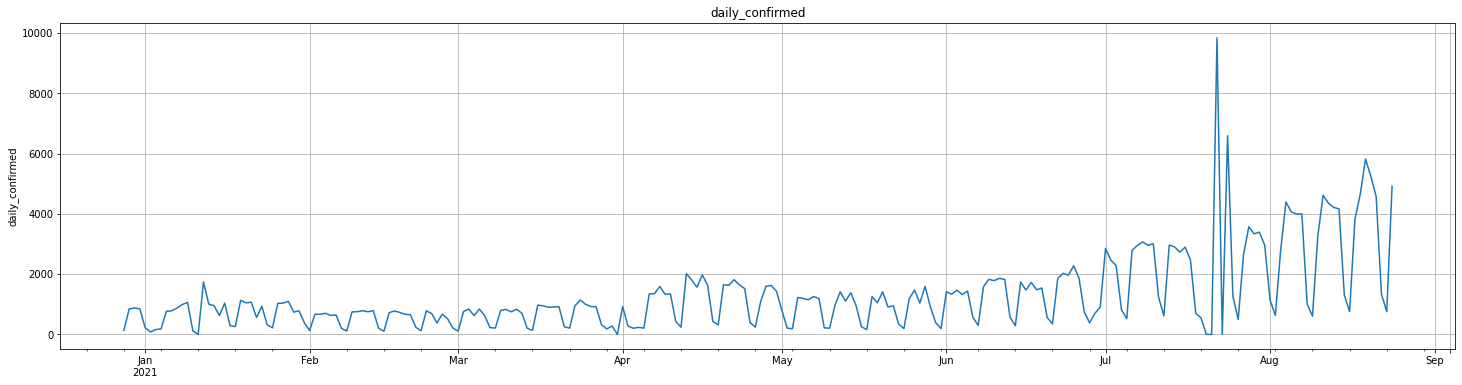

In [115]:
#Grafica de los datos 
target_column = "daily_confirmed" #@param {type:"string"}
month =  8#@param {type:"number"}
title = target_column
ylabel = target_column
xlabel = ''
figsize = (25,6)

ax = df[target_column][-30*month:].plot(figsize=figsize, title=title)
ax.autoscale(axis='x', tight=False)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.grid()


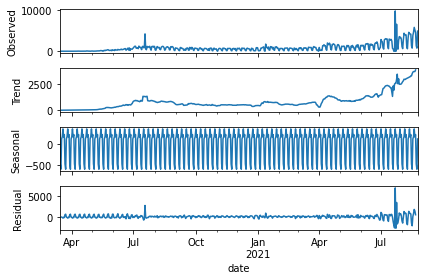

In [8]:
#Descomposicion de la serie temporal 
result = seasonal_decompose(df[target_column])
result.plot( );

In [117]:
#PREPAR DATOS 
# Crear datos de entrnamiento y test 
target = df[target_column].values.astype(float)
window_size = 8
test_size = 16
train_set = target[:-test_size]
test_set = target[-test_size:]

# Normalizar los datos (https://en.wikipedia.org/wiki/Feature_scaling)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

# Datos de entranmiento 
train_norm = torch.FloatTensor(train_norm).view(-1).cuda() #https://pytorch.org/docs/stable/tensor_view.html
train_data = input_data(train_norm, window_size)

# Imprimir resultados
print(f'- train_norm.min = {train_norm.min()} \n- train_norm.max = {train_norm.max()} \
      \n- train_norm.mean = {train_norm.mean()} \n- train_norm tipo = {type(train_norm)}')

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

- train_norm.min = -1.0 
- train_norm.max = 1.0       
- train_norm.mean = -0.8453716039657593 
- train_norm tipo = <class 'torch.Tensor'>
Train: 513
Test:  16


# Arquitectura Red Neuronal

In [103]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=100, output_size=1):
      super().__init__()
      self.hidden_size = hidden_size
      
      # Agrear una celda LSTM :
      self.lstm = nn.LSTM(input_size,hidden_size)
      
      # Agregar una capa full connect:
      self.linear = nn.Linear(hidden_size,output_size)
      
      # Inicializar valores de h0 y c0:
      self.hidden = (torch.zeros(1,1, self.hidden_size),
                      torch.zeros(1,1, self.hidden_size))

  def forward(self,seq):
      lstm_out, self.hidden = self.lstm(
          seq.view(len(seq),1,-1), self.hidden)
      pred = self.linear(lstm_out.view(len(seq), -1))
      return pred[-1]  # Solo se requiere los ultimos valores de la ventana  

In [118]:
#Instanciamos el modelo 
torch.manual_seed(101)
model = LSTM(1, 70).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(f'- model (cuda): {next(model.parameters()).is_cuda}')
print(f'\nARQUITECTURA: \n{model}')

- model (cuda): True

ARQUITECTURA: 
LSTM(
  (lstm): LSTM(1, 70)
  (linear): Linear(in_features=70, out_features=1, bias=True)
)


Epoch:  2 Loss: 0.15276434
Epoch: 12 Loss: 0.11720748
Epoch: 22 Loss: 0.08150712
Epoch: 32 Loss: 0.00212459
Epoch: 42 Loss: 0.00097051
Epoch: 52 Loss: 0.00893395
Epoch: 62 Loss: 0.00069719
Epoch: 72 Loss: 0.00566067
Epoch: 82 Loss: 0.00227367
Epoch: 92 Loss: 0.00038683

Loss: 0.00670690

Duration: 128 seconds


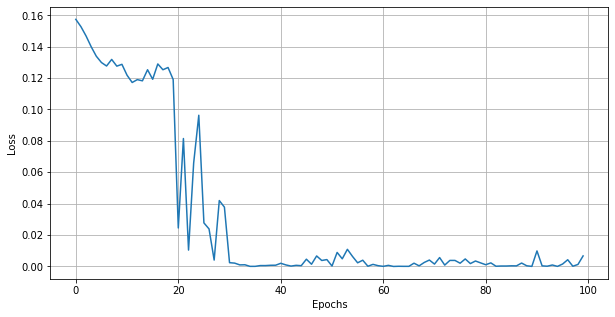

In [107]:
#ENTRENAMIENTO CON DATOS TRAIN
epochs = 100
model.train() 

#Entrenamiento del modelo 
model_fit(epochs, train_data, model, criterion, optimizer)

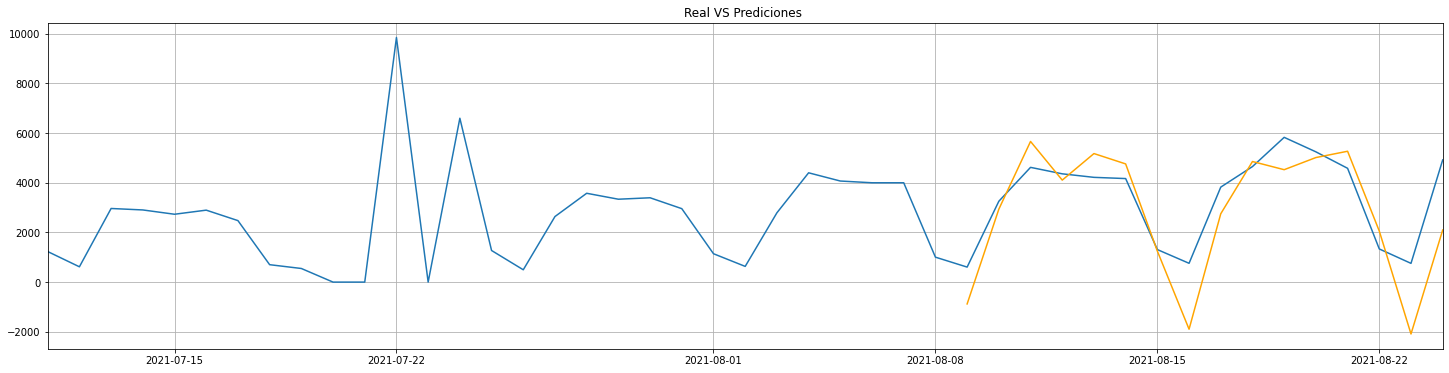

In [113]:
#Evaluar resultados de entrenamiento
future = test_size #Valor a predecir a futuro 
x_train_plot = 45
model.eval() # colocamos el modelo en modo de evaluacion 

# Agregar los valores de entranamiento de la ultima ventana a la lista de predicciones 
pred_test = train_norm[-window_size:].tolist()

for i in range(future):
    sequence = torch.FloatTensor(pred_test[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                        torch.zeros(1, 1, model.hidden_size).cuda())
        
        pred_test.append(model(sequence).item())

# Invertimos la normalizacion de los datos 
predictions_test = scaler.inverse_transform(np.array(pred_test[window_size:]).reshape(-1, 1) )

# Grafica comparativo Real VS Prediccion 
x_test_plot = np.array(df.index[-future:], dtype='datetime64[D]')

plt.figure(figsize=figsize)
plt.title('Real VS Prediciones ')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.iloc[:,3][df.index[-x_train_plot:]])
plt.plot(x_test_plot, predictions_test, "orange")
plt.show()

Epoch:  2 Loss: 0.12328607
Epoch: 12 Loss: 0.18965074
Epoch: 22 Loss: 0.00420256
Epoch: 32 Loss: 0.00096631
Epoch: 42 Loss: 0.00076378
Epoch: 52 Loss: 0.00021898
Epoch: 62 Loss: 0.01262211
Epoch: 72 Loss: 0.00106213
Epoch: 82 Loss: 0.00006269
Epoch: 92 Loss: 0.00004115

Loss: 0.00000176

Duration: 130 seconds


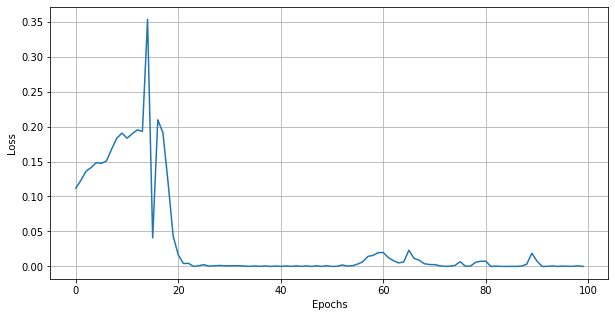

In [120]:

#ENTRENAMIENTO CON TODO LOS DATOS 
epochs = 100
model.train() 

# feature scale the entire dataset
target_norm = scaler.fit_transform(target.reshape(-1, 1))
target_norm = torch.FloatTensor(target_norm).view(-1).cuda()
all_data = input_data(target_norm, window_size)

#Entrenamiento del modelo 
model_fit(epochs, all_data, model, criterion, optimizer)

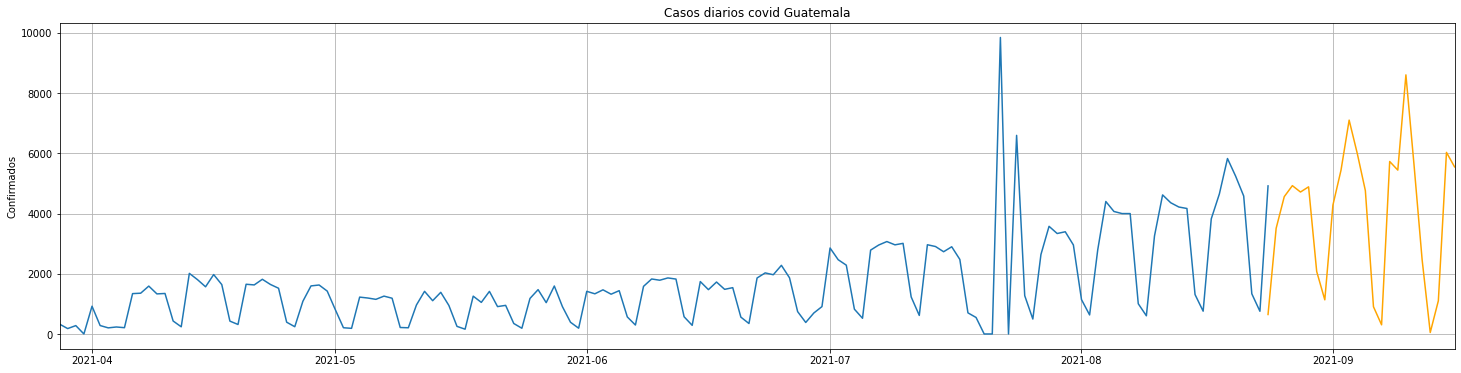

In [141]:

#Evaluar resultados de entrenamiento
future = 24 #Valor a predecir a futuro 
model.eval() # colocamos el modelo en modo de evaluacion 

# Agregar los valores de entranamiento de la ultima ventana a la lista de predicciones 
pred_test = train_norm[-window_size:].tolist()

for i in range(future):
    sequence = torch.FloatTensor(pred_test[-window_size:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                        torch.zeros(1, 1, model.hidden_size).cuda())
        
        pred_test.append(model(sequence).item())

# Invertimos la normalizacion de los datos 
predictions_test = scaler.inverse_transform(np.array(pred_test[window_size:]).reshape(-1, 1) )

# Grafica comparativo Real VS Prediccion 
x_train_plot = 5  #Meses
x_test_plot = np.arange(df.index[-1], df.index[-1] + relativedelta(days=+future), dtype='datetime64[D]')
plt.figure(figsize=figsize)
plt.title('Casos diarios covid Guatemala')
plt.ylabel('Confirmados')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df.iloc[:,3][df.index[-x_train_plot*30:]])
plt.plot(x_test_plot, predictions_test, "orange")
plt.show()